In [22]:
# Load the autoreload extension for development 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Change working directory to the notebook location for debugging
import os
notebook_path = os.getcwd()+"/python/bls_cuda"
os.chdir(notebook_path)
print("Changed working directory to:", os.getcwd())

Changed working directory to: /home/rowe/python/bls_cuda


## Example Notebook to use PyTFit5 with BLS CPU version and TransitFit5 transit modelling.

### VS Code Virtual Environment Setup
If you are using VS Code, it is recommended to create a virtual environment for this project. Here are the steps to create a virtual environment in VS Code:

- Open the Command Palette: Press Ctrl+Shift+P (or Cmd+Shift+P on Mac).
- Search: Type Python: Create Environment and select it.
- Choose Type: Select Venv.
- Select Interpreter: Choose the base Python version you have installed (e.g., Python 3.10, 3.11).
- Wait: VS Code will create a .venv folder in your project and automatically select it as your environment.

It is recommended to install this package in "editable" mode inside a virtual environment. This allows you to modify the source code without needing to reinstall.

```bash
git clone https://github.com/jasonfrowe/bls_cuda.git
cd bls_cuda
```

Install via pip:
```bash
pip install -e .
```

### Alternative Virtual Environment Setup
If you are not using VS Code, you can still create a virtual environment using the command line:

```bash
python -m venv bls_env         # Install create virtual environment that we will name 'bls_env'
source ./bls_env/bin/activate   # Active the new environment
pip install ipykernel           # Install iPython kernel
python -m ipykernel install --user --name=bls_env  # Add Kernel to Jupyter
(now make sure you have selected `bls_env` as your active Kernel for this notebook)
```

It is recommended to install bls_cuda package in "editable" mode inside a virtual environment. This allows you to modify the source code without needing to reinstall.

```bash
git clone https://github.com/jasonfrowe/bls_cuda.git
cd bls_cuda
```

Install via pip:
```bash
pip install -e .
```
### Package requirements:
- pytfit5
- numpy
- matplotlib
- tqdm
- numba
- scipy
- astroquery
- pandas

```bash
pip install numpy matplotlib tqdm numba scipy astroquery pandas
```

It is also recommended to install ipywidgets for Jupyter notebooks
```bash
pip install ipywidgets
```

In [3]:
import numpy as np
import pytfit5.bls_cpu as gbls
import pytfit5.transitPy5 as tpy5

import matplotlib.pyplot as plt  #MatPlotLib for some simple plots 

import importlib.util #To check if certain libraries are available 

In [4]:
tpy5_inputs = tpy5.tpy5_inputs_class() # Initialize unified inputs class (replaces gbls_inputs)

tic = 29991541
# tpy5_inputs.lcdir    = "./"
# tpy5_inputs.filename = "tlc"+str(tic)+"_5.d.dat"

tpy5_inputs.lcdir = "/opt/data2/TESS/ffisearch/cvzsearch_yr1/candidates/canrev_dataset1/"
tpy5_inputs.filename = "tlc140511927/tlc140511927.p.dat"

# Read in photometry to photclass
phot = tpy5.readphot(tpy5_inputs.lcdir + tpy5_inputs.filename)
phot.ferr = np.std(phot.flux) * np.ones_like(phot.flux)  # Set constant error bars if none exist, or errors are poorly defined.  

# Data should be normalized around 1 for BLS.  The example is centred around 0.  So we fix that here.
# phot.flux += 1.0  # Ensure flux is around 0
# phot.flux_f = phot.flux   # Make a copy of original flux

# Remove any offset from time stamps
tpy5_inputs.zerotime = 1325.0

# 0 == no plots ; 1 = make a plot ; 2 make a plot and save it ; 3 just save the plot
tpy5_inputs.plots = 1  #default is 1 

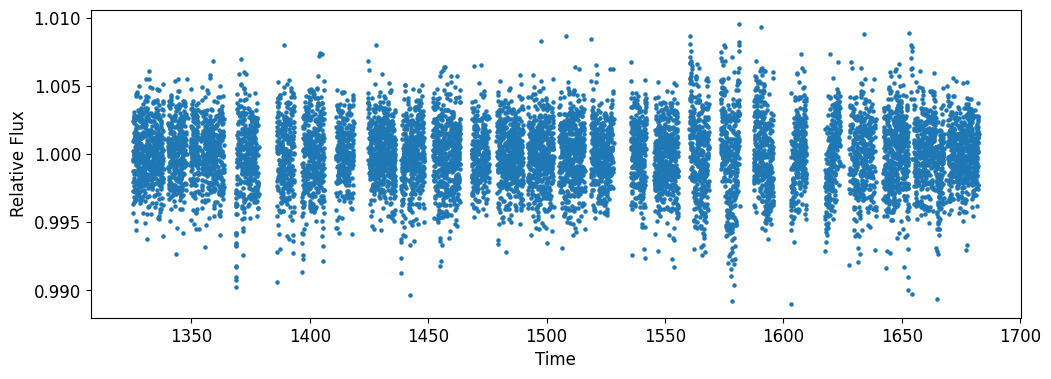

In [5]:
# Raw Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot.time,phot.flux, s=5)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.show()

Starting clipping: Window=2.0 days, Sigma=3.0
  Iteration 1: flagged 27 new outliers.
  Iteration 2: flagged 3 new outliers.
  Iteration 3: flagged 1 new outliers.
  Iteration 4: flagged 0 new outliers.


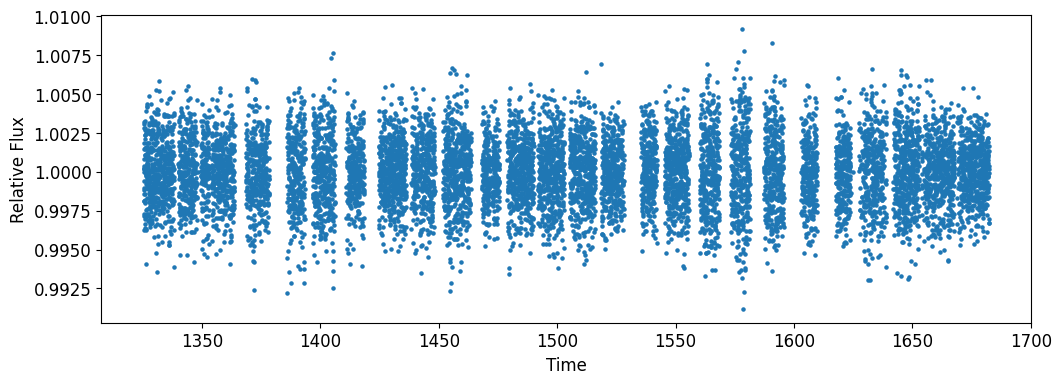

In [6]:
## For testing detrending and outlier removal (can be removed)
phot.flux_f = np.copy(phot.flux)                # Make a copy of original flux
phot.icut = np.zeros(len(phot.time), dtype=int) # Initialize icut array to zero (good data)

# Get default parameters
tpy5_inputs = tpy5.tpy5_inputs_class()

# Run the detrending and outlier detection (if needed) 
tpy5_inputs.boxbin = 5.0 # set detrending length
tpy5_inputs.nfitp  = 3   # Set polynomial order
tpy5.run_polyfilter_iterative(phot, tpy5_inputs)  # flux_f will contain the filtered photometry
tpy5.run_cutoutliers(phot, tpy5_inputs) # data clipping, phot.icut will flag bad data
# tpy5.run_sigclip_global(phot, tpy5_inputs) # Simple sigma-clipping of data
tpy5.time_window_clip(phot, tpy5_inputs)  # Example of custom time-window clipping function

# Processed Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot.time[(phot.icut==0)],phot.flux_f[(phot.icut==0)], s=5)
# plt.scatter(phot.time[phot.icut==0],phot.flux_f[phot.icut==0], s=5)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.show()

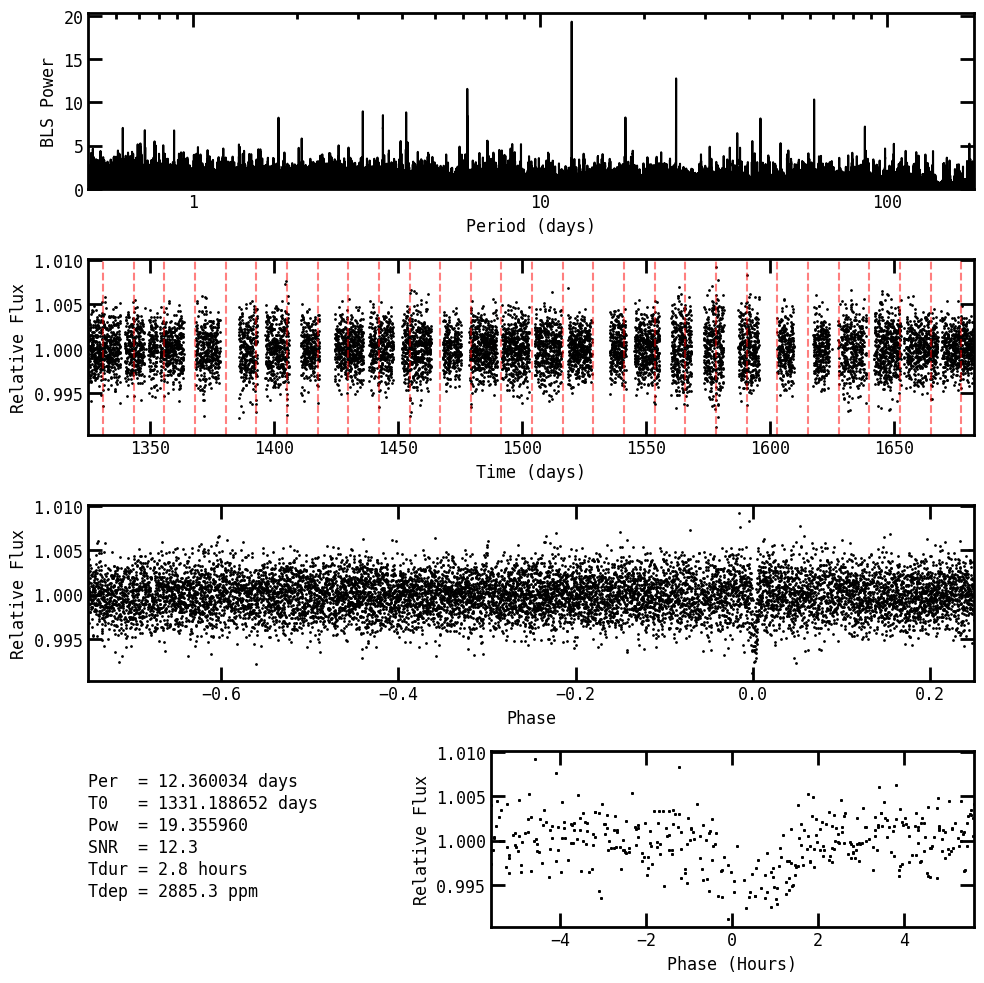

In [7]:
# Set up the BLS inputs and run
# Note: tpy5_inputs now contains both BLS and detrending parameters
tpy5_inputs.zerotime = 0.0
tpy5_inputs.rstar    = 1.0
tpy5_inputs.mstar    = 1.0
tpy5_inputs.plots    = 1 # 1=X11, 2=both, 0=none
# Set frequency range
# For long periods: frequency = 1/period (cycles/day = 1/days)
# To search down to period = baseline, use freq1 = 1/baseline
tpy5_inputs.freq1    = 2 / (np.max(phot.time) - np.min(phot.time))  # Longest period = dataset length
tpy5_inputs.freq2    = -1 # default is 2.0 c/d (period = 0.5 days)
tpy5_inputs.filename = "BLS_Test"  # Used for naming the file, extension replaced with PNG.


tpy5_inputs.normalize = "iterative_baseline"  # "coverage_mad" "mad", "percentile_mad", "none"

# Run BLS, applying data cuts (now using unified tpy5_inputs)
gbls_ans = gbls.bls(tpy5_inputs, phot.time[(phot.icut==0)], \
                                 phot.flux_f[(phot.icut==0)])

## Lightcurve Summary Plot

Use `transitp.plot_lightcurve_summary()` to visualize raw and detrended photometry, optionally with BLS results.

In [8]:
import pytfit5.transitplot as transitp

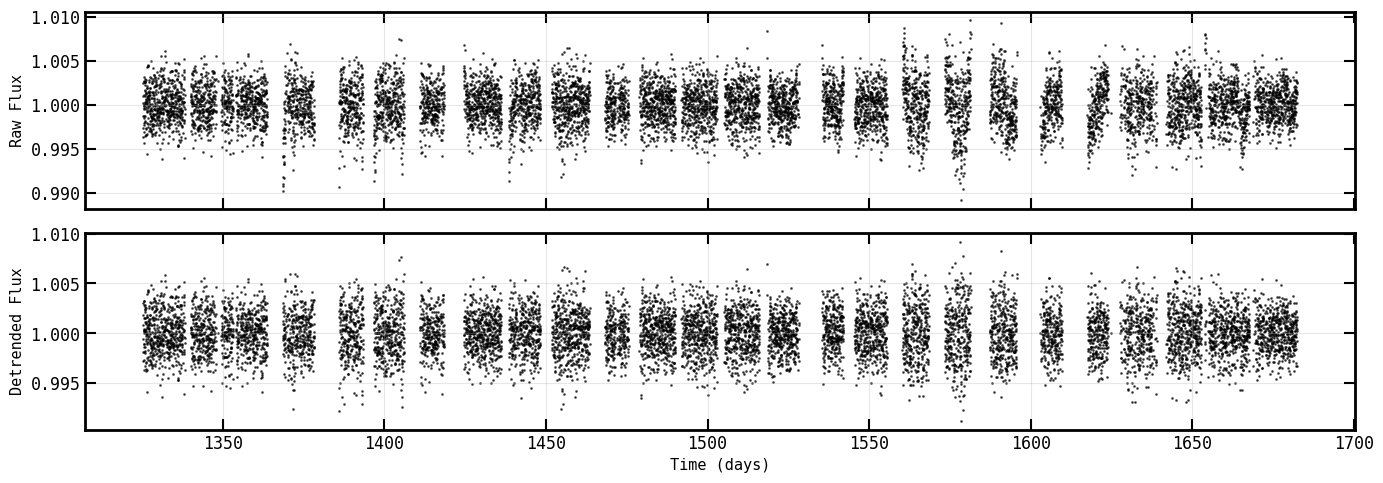

In [9]:
# Plot summary without BLS results (just raw and detrended)
fig = transitp.plot_lightcurve_summary(phot, tpy5_inputs=tpy5_inputs)

/home/rowe/python/bls_cuda/pytfit5/transitplot.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


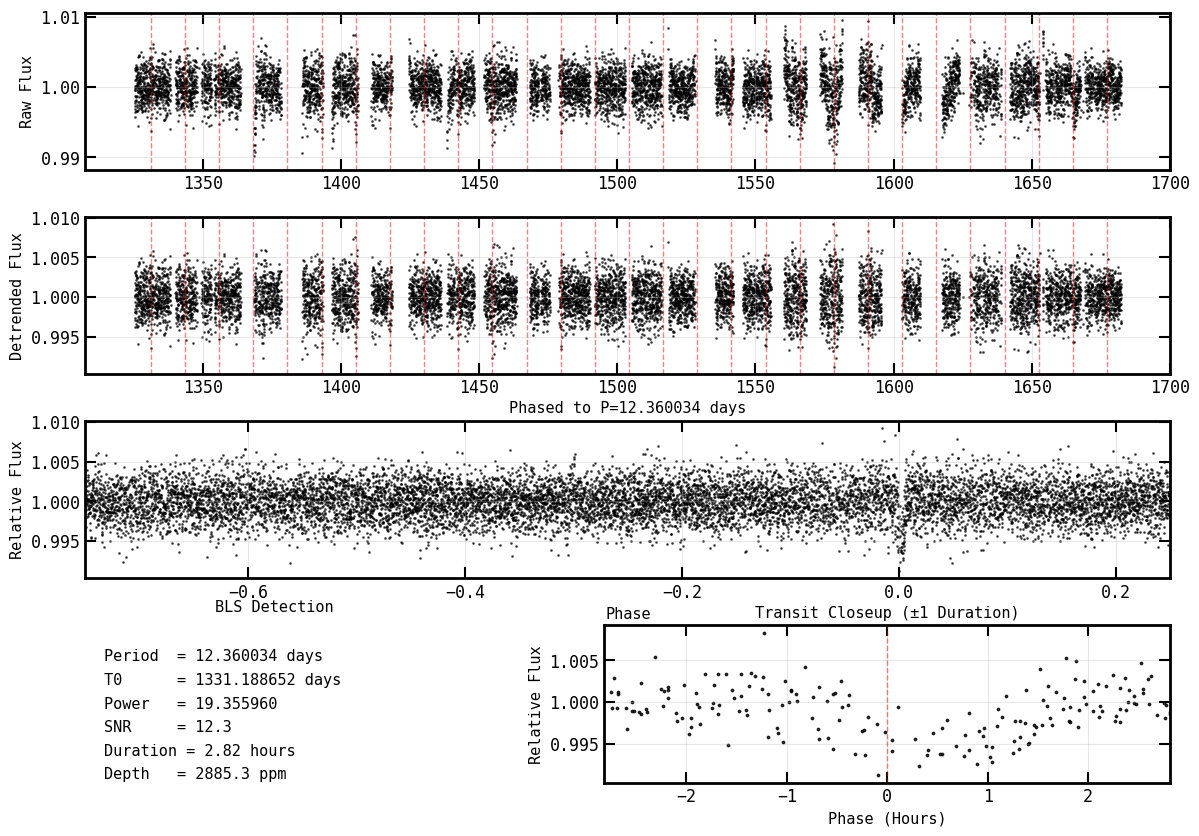

In [10]:
# Plot summary with BLS results (includes phased lightcurve and transit closeup)
fig = transitp.plot_lightcurve_summary(phot, bls_ans=gbls_ans, tpy5_inputs=tpy5_inputs)

## Python Transit modelling section

- needs preconditioning of data prior to modelling. (protect transits during detrending and clipping)
- move zerotime to routine to leave original phot.time intack
- use flux_f instead of flux for modelling -- leaves original photometry intack
- use icut and other flags to mark bad data 

In [54]:
import pytfit5.transitmodel as transitm
import pytfit5.keplerian as kep
import pytfit5.transitfit as transitf
import pytfit5.transitplot as transitp

# Check for optional exotic limb darkening package.
if importlib.util.find_spec("exotic_ld"):
    from exotic_ld import StellarLimbDarkening
    use_exotic_ld = 1
else:
    use_exotic_ld = 0

In [16]:
# Create an initial guess for all 18 parameters
sol     = transitm.transit_model_class() # Single planet model has up-to 18-model parameters

# Parameters that define the star/scene for the transit model
sol.rho = kep.rhostar(gbls_ans.bper, gbls_ans.tdur)    # Guess for mean stellar density based on transit-duration and period (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening 
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0    # Photometric zero point

# Set up Limb-darkening (q1, q2 parameterization)
if use_exotic_ld == 1:
    ld_data_path = './exotic_ld_data/'  #location of exotic spectral library 
    ld_model = 'mps1'
    sld = StellarLimbDarkening(tpy5_inputs.feh, tpy5_inputs.teff, tpy5_inputs.logg, ld_model, ld_data_path)
    ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
    sol.nl3 = ld[0]
    sol.nl4 = ld[1]
else:
    sol.nl3 = 0.311 #Solar values for TESS
    sol.nl4 = 0.270 

#The parameters below are stored as arrays, as the model is multi-planet ready.
sol.t0  = [gbls_ans.epo]             # Center of transit time (days)
sol.per = [gbls_ans.bper]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans.depth)]  # Rp/R*
sol.ecw = [0.0]                      # sqrt(e)cos(w)
sol.esw = [0.0]                      # sqrt(e)sin(w)
sol.krv = [0.0]                      # RV amplitude (m/s)
sol.ted = [0.0]                      # thermal eclipse depth (ppm)
sol.ell = [0.0]                      # Ellipsodial variations (ppm)
sol.alb = [0.0]                      # Albedo amplitude (ppm)
sol.npl = 1                          # Number of planets

In [17]:
# Mark in-transit data.  Since BLS will likely underestimate the transit-duration, we will pad to be safe.
kep.mark_intransit_data(phot, sol, tdurcut = 1.0)  # tdurcut is the amount of +/- time to protect centred on the transit 
tpy5.run_polyfilter(phot, tpy5_inputs)         # Re-apply detrending to protect the transit event from distortion

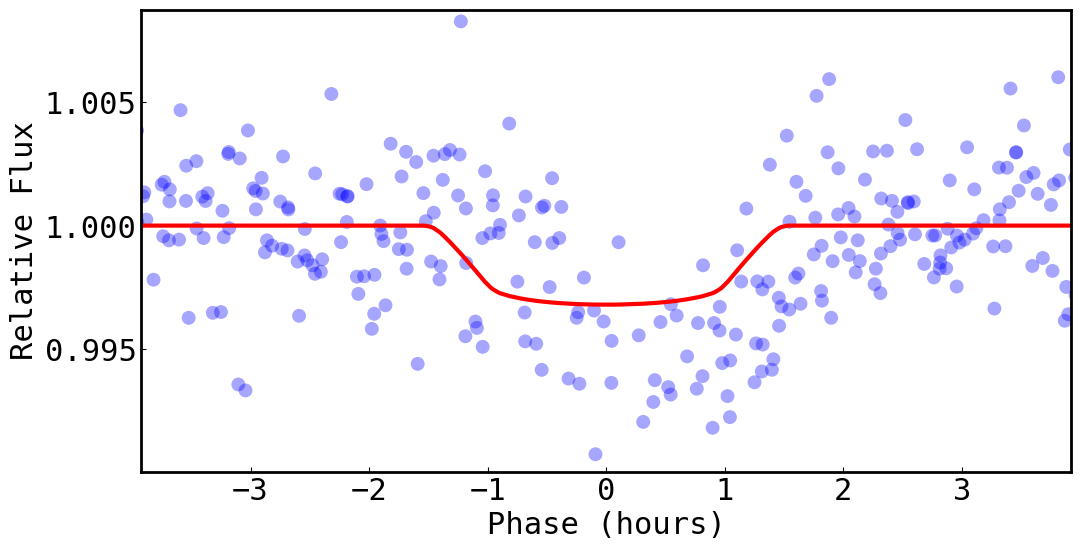

In [18]:
# Plot the initial model and data
pl_plot = 1 # Which planet to plot
transitp.plotTransit(phot, sol, pl_to_plot=pl_plot)

In [19]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

# Fit the data
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot)

In [20]:
# See the fitted parameter (Note the error is a simple co-variance matrix at this stage)
transitp.printParams(sol_fit)

ρ* (g/cm³):                    17.4694674 ± 151.1662787
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                 0.311 ± 0.0
q2:                                  0.27 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:        -1.366e-04 ± 2.251e-04
t0 (days):                      1.331e+03 ± 3.131e-03
Period (days):                 12.3590484 ± 0.0001938
Impact parameter:               0.1847128 ± 15.0535316
Rp/R*:                          0.0697832 ± 0.0341541
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


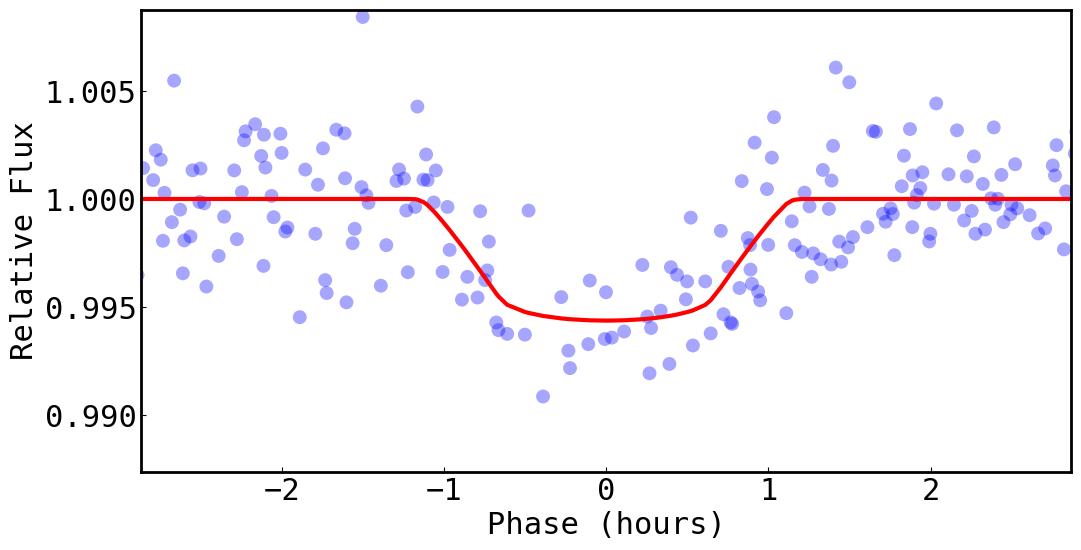

In [21]:
# Plot the optimized model and data
pl_plot = 1
transitp.plotTransit(phot, sol_fit, pl_to_plot=pl_plot)

## MCMC

- add tqdm to MCMC chain generation to give user an indication of progress
- add flag to remove verbose output
- add figure generation that plots a selection of models from MCMC to show scatter. 

In [15]:
import pytfit5.transitmcmc as tmcmc

In [16]:
nsteps1 = 10000 #total length of chain will be nwalkers*nsteps
nsteps2 = 50000#200000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 50000#100000
burninf=0.2 #burn-in for evalulating convergence
niter_cor=10000
burnin_cor=1000
nthin=101
nloopmax=5
converge_crit=1.02 #Convergence criteria
buf_converge_crit=1.2 #Convergence criteria for buffer

In [17]:
if np.rint(np.median(phot.flux)) != 1:
    raise ValueError

# Generate input for mcmc
lnprob, x, beta = tmcmc.genmcmcInput(sol_fit, params_to_fit)  # Beta can be crap when pulled from least-squares...

# # beta is the step size for each parameter in x and initialized from the covariance matrix.
# # Here we set some reasonable values for our parameters to fit. 
# beta[0] = 0.01 # Set a reasonable step size for stellar density
# beta[1] = 0.00001 # Set a reasonable step size for photometric zero point
# beta[2] = 0.00001 # Set a reasonable step size for transit time
# beta[3] = 0.00001 # Set a reasonable step size for period
# beta[4] = 0.1  # Set a reasonable step size for impact parameter
# beta[5] = 0.0001 # Set a reasonable step size for radius ratio

sol_a = sol_fit.to_array()
serr = sol_fit.err_to_array()

# Cut out of transit
phot_cut = tmcmc.cutOutOfTransit(sol_fit, phot)

params = [nsteps1, nsteps2, nsteps_inc, burninf, niter_cor, burnin_cor, nthin, nloopmax, converge_crit, buf_converge_crit]

In [18]:
# Run the DEMCMC routine.
chain, accept, burnin = tmcmc.demcmcRoutine(x, beta, phot_cut, sol_a, serr, params, lnprob)

runtest: [0.00468241 0.00273579 0.00026593 0.0002557 ]
Current Acceptance:  [0.02416107 0.65784249 0.53406745 0.58366013 0.01043025 0.08999328]
Current Acceptance:  [0.02416107 0.65784249 0.53406745 0.58366013 0.01043025 0.08999328]
Current Acceptance:  [0.05662891 0.39600551 0.35852982 0.34996717 0.02216428 0.17041801]
Current Acceptance:  [0.05662891 0.39600551 0.35852982 0.34996717 0.02216428 0.17041801]
Current Acceptance:  [0.22062663 0.19257837 0.19090283 0.1854083  0.1473755  0.25118163]
Current Acceptance:  [0.22062663 0.19257837 0.19090283 0.1854083  0.1473755  0.25118163]
Current Acceptance:  [0.22062663 0.12777404 0.15534633 0.14769648 0.43147541 0.25118163]
Current Acceptance:  [0.22062663 0.12777404 0.15534633 0.14769648 0.43147541 0.25118163]
Current Acceptance:  [0.22062663 0.15740121 0.15505913 0.19354839 0.49698593 0.25118163]
Current Acceptance:  [0.22062663 0.15740121 0.15505913 0.19354839 0.49698593 0.25118163]
Current Acceptance:  [0.22062663 0.21494102 0.22266667 

In [19]:
# Get statistics about the posterior from the Markov-Chain and print the results
sol_mcmc = tmcmc.getParams(chain, burnin, sol, params_to_fit)
transitp.printParams(sol_mcmc)

# you can get any individual value from the sol_mcmc class, for example the mean stellar density : rho and drho 

ρ* (g/cm³):                    10.1258254 ± 11.3507657
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                 0.311 ± 0.0
q2:                                  0.27 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:        -1.260e-04 ± 2.356e-04
t0 (days):                      1.331e+03 ± 3.721e-03
Period (days):                 12.3590832 ± 0.0002608
Impact parameter:               0.5477278 ± 0.3499818
Rp/R*:                          0.0720026 ± 0.0302294
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


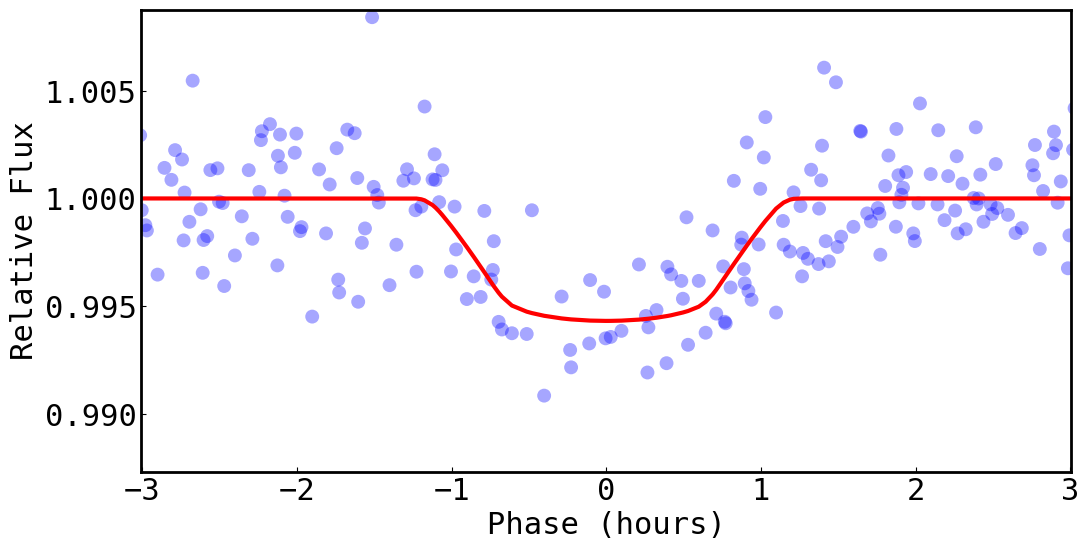

In [20]:
pl_plot = 1
transitp.plotTransit(phot, sol_mcmc, pl_to_plot=pl_plot)

In [21]:
import pytfit5.mcmcroutines as mcmc

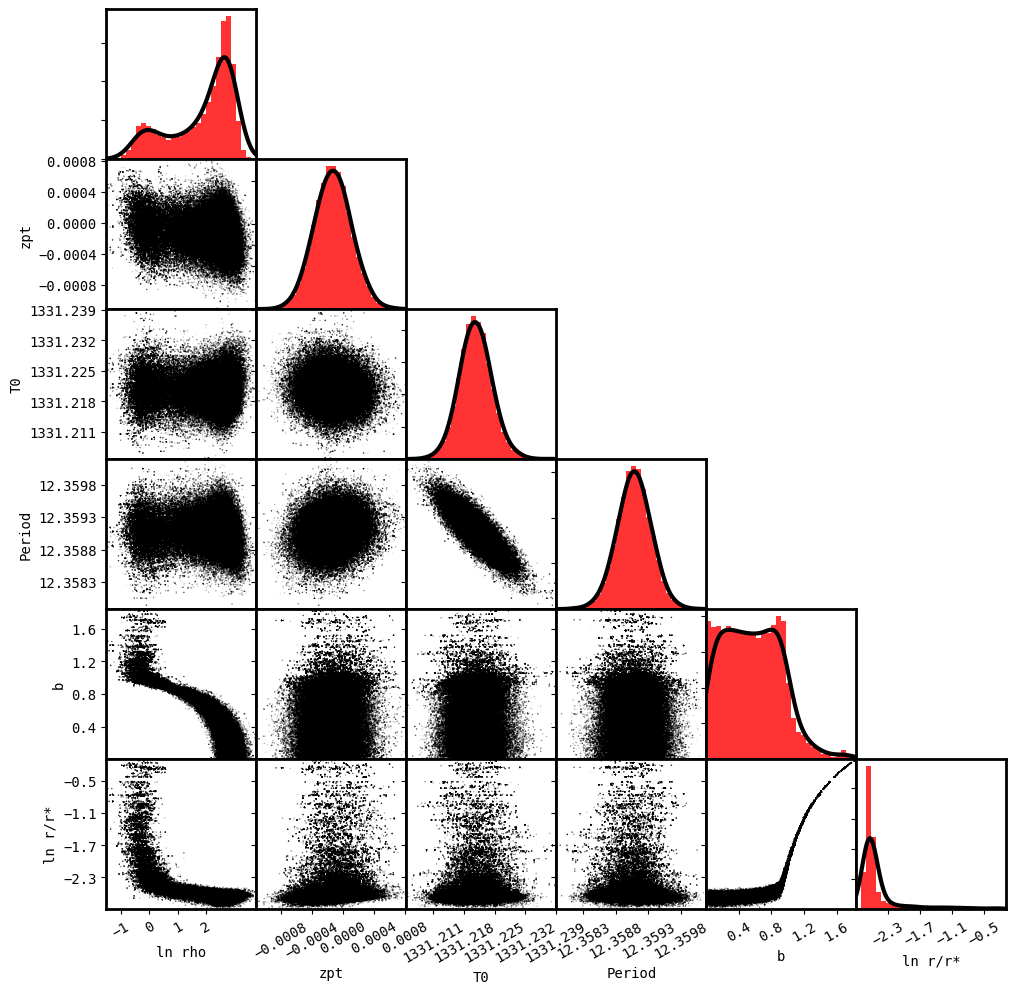

In [22]:
label = ["ln rho", "zpt", "T0", "Period", "b", "ln r/r*"]
color = ["red"]*14

plt.rcParams['font.size'] = 10
mcmc.triplot(chain, burnin, label, color, 30)

## Synthetic Lightcurve Generator Demo

Use `pytfit5.synthetic.generate_synthetic_lightcurve` to create a simple Sun-like transit signal for BLS testing.

In [11]:
# Generate synthetic photometry and run BLS
from pytfit5.synthetic import generate_synthetic_lightcurve

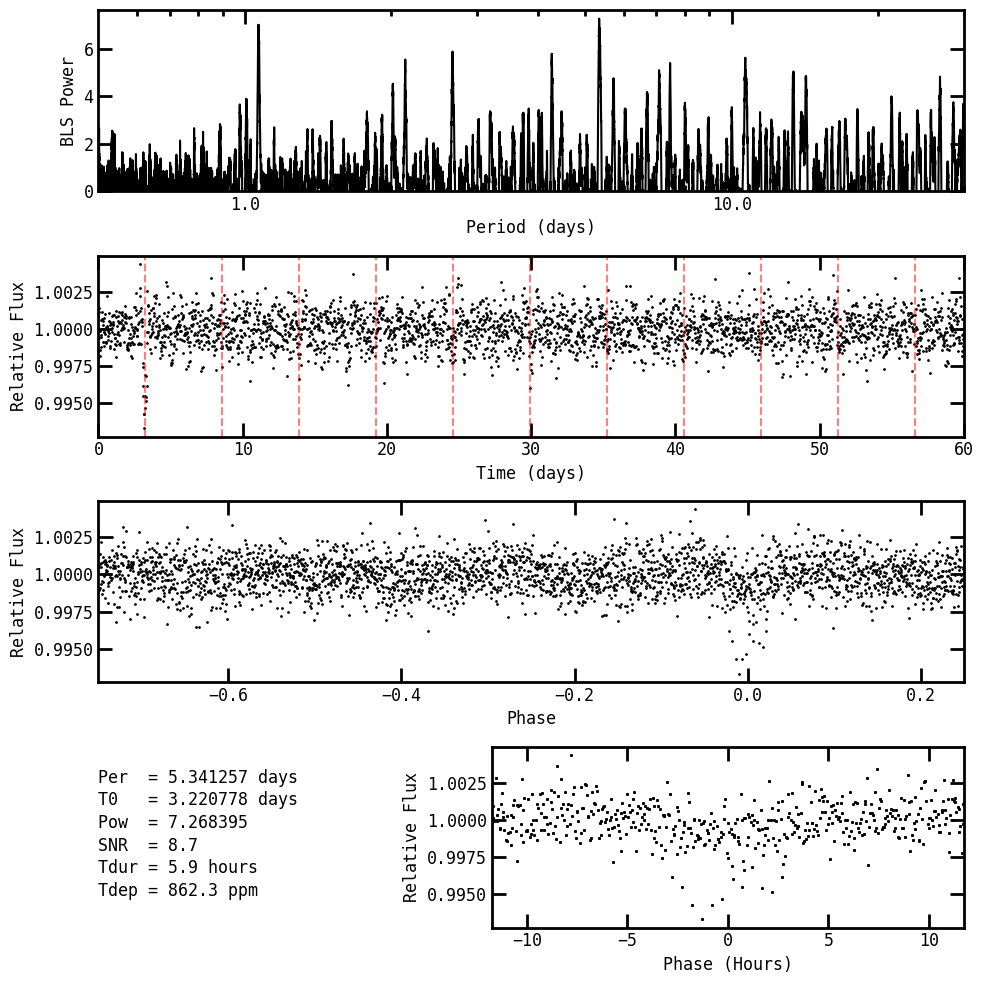

Best period: 5.341257 days
Best power: 7.268395
SNR: 8.69
Duration: 0.245698 days (5.90 hours)
Depth: 0.000862 (862.3 ppm)

Spectrum returned: False
Periodic SNR: 8.69
Single SNR:   13.86
>> Single Event candidate has higher SNR. Adopting single event parameters.
   Estimated Period: 60.42 days (Single Transit)
   Epoch: 3.2014
   Depth: -0.004343
   Duration: 0.2778 days


In [23]:
# Generate synthetic photometry using new phot_class return format
phot_syn, sol_injected = generate_synthetic_lightcurve(
    t0=3.2,            # days
    per=86.05,         # days
    time_length=60.0,  # days total baseline
    depth=0.005,       # 0.5% depth
    snr=20.0,          # integrated transit SNR
    cadence=1.0/48.0,  # 30-min cadence
    stellar_noise_type='multi',  # 'none', 'red', 'drw', or 'multi'
    stellar_noise_amplitude=0.005,  # RMS amplitude of stellar noise
    rotation_period=None,  # Stellar rotation period (days) for spot modulation
    seed=42
)

# phot_syn is now a phot_class object with:
# - phot_syn.time: observation times
# - phot_syn.flux: flux with transit + noise
# - phot_syn.ferr: flux errors
# - phot_syn.itime: integration times
# - phot_syn.tflag: in-transit flags (0=out, 1=in)
# - phot_syn.icut: data quality flags (0=good, 1=bad)
# - phot_syn.flux_f: copy of flux for detrending

# Configure BLS for synthetic data - using unified tpy5_inputs
syn_inputs = tpy5.tpy5_inputs_class()
syn_inputs.zerotime = 0.0
syn_inputs.rstar = 1.0
syn_inputs.mstar = 1.0
syn_inputs.plots = 1
syn_inputs.freq1 = 2.0 / (np.max(phot_syn.time) - np.min(phot_syn.time))  # longest period = baseline
syn_inputs.freq2 = 2.0  # c/d
syn_inputs.filename = "BLS_Synthetic"


# Optional: Run detrending and outlier detection if needed
syn_inputs.boxbin = 2.0  # set detrending length
syn_inputs.nfitp  = 2    # Set polynomial order
# tpy5.run_polyfilter(phot_syn, syn_inputs)
tpy5.run_polyfilter_iterative(phot_syn, syn_inputs)   # flux_f will contain filtered photometry
# tpy5.run_cutoutliers(phot_syn, syn_inputs)  # data clipping, phot.icut will flag bad data
# tpy5.time_window_clip(phot_syn, syn_inputs) # Custom time-window clipping

# Enable 1/f noise correction for synthetic data
syn_inputs.oneoverf_correction = True  # Set to False to disable 1/f correction
syn_inputs.oneoverf_extrapolate = False  # Enable extrapolation of baseline/noise

# Normalization options: "none", "mad", "percentile_mad", "coverage_mad", "iterative_baseline"
# For high SNR signals, "iterative_baseline" is more robust against suppressing the main peak
syn_inputs.normalize = "iterative_baseline"
syn_inputs.return_spectrum = False  # Return full BLS spectrum

# Run BLS on synthetic data - now using phot_syn.time and phot_syn.flux
syn_ans = gbls.bls(syn_inputs, phot_syn.time, phot_syn.flux_f)

# Display results
print(f"Best period: {syn_ans.bper:.6f} days")
print(f"Best power: {syn_ans.bpower:.6f}")
print(f"SNR: {syn_ans.snr:.2f}")
print(f"Duration: {syn_ans.tdur:.6f} days ({syn_ans.tdur*24:.2f} hours)")
print(f"Depth: {syn_ans.depth:.6f} ({syn_ans.depth*1e6:.1f} ppm)")
print(f"\nSpectrum returned: {syn_ans.periods is not None}")
if syn_ans.periods is not None:
    print(f"  Periods array: {len(syn_ans.periods)} points")
    print(f"  Power array: {len(syn_ans.power)} points")
    print(f"  Period range: {syn_ans.periods.min():.2f} - {syn_ans.periods.max():.2f} days")


# 3. Run Pulse Search (returns SNR directly now)
pulse_res = gbls.compute_pulse_search(phot_syn.time, phot_syn.flux_f, min_duration_hours=1.0, max_duration_hours=8.0)
snr_single = pulse_res['snr']

print(f"Periodic SNR: {syn_ans.snr:.2f}")
print(f"Single SNR:   {snr_single:.2f}")

# 4. Consolidate Results
from pytfit5 import period_validation as pval

# Create a new output object based on gbls_ans_class
final_ans = gbls.gbls_ans_class()

if snr_single > syn_ans.snr:
    print(">> Single Event candidate has higher SNR. Adopting single event parameters.")
    
    # Populate final_ans with pulse results
    final_ans.epo = pulse_res['t0']
    final_ans.depth = pulse_res['depth']
    final_ans.tdur = pulse_res['duration']
    final_ans.snr = pulse_res['snr']
    final_ans.bpower = pulse_res['snr'] # Using SNR as power proxy for single event
    
    # Estimate period for single transit
    P_est, P_min, is_constrained, n_transits = pval.estimate_single_transit_period(
        time=phot_syn.time,
        tdur=final_ans.tdur,
        rho_star=pval.get_stellar_density(syn_inputs.mstar, syn_inputs.rstar),
        margin_factor=1.5
    )
    final_ans.bper = P_est
    print(f"   Estimated Period: {final_ans.bper:.2f} days (Single Transit)")
    print(f"   Epoch: {final_ans.epo:.4f}")
    print(f"   Depth: {final_ans.depth:.6f}")
    print(f"   Duration: {final_ans.tdur:.4f} days")

else:
    print(">> Periodic signal has higher SNR. Adopting periodic parameters.")
    # Copy syn_ans to final_ans
    final_ans.epo = syn_ans.epo
    final_ans.bper = syn_ans.bper
    final_ans.depth = syn_ans.depth
    final_ans.tdur = syn_ans.tdur
    final_ans.snr = syn_ans.snr
    final_ans.bpower = syn_ans.bpower
    final_ans.periods = syn_ans.periods
    final_ans.power = syn_ans.power
    final_ans.freqs = syn_ans.freqs
    
    print(f"   Period: {final_ans.bper:.4f} days")
    print(f"   Epoch: {final_ans.epo:.4f}")
    print(f"   Depth: {final_ans.depth:.6f}")
    print(f"   Duration: {final_ans.tdur:.4f} days")

# Update syn_ans to point to the best result for downstream analysis
syn_ans = final_ans

## Period Validation

After BLS finds a period, we should validate it by checking for:
1. **Period aliases**: Is the reported period a multiple/fraction of the true period? (2×, 3×, 4×, 5×, 0.5×)
2. **Single-transit events**: Do we only have one transit? If so, the period is not well constrained.

The validation works by computing SNR for different period hypotheses and optimizing the epoch (t0) for each.

In [ ]:
# Import the period validation module
from pytfit5 import period_validation as pval
import pytfit5.keplerian as kep

In [166]:
# Validate the BLS result from the synthetic data
# This will test period factors: 0.5×, 1.0×, 2.0×, 3.0×, 4.0×, 5.0×
results, transit_info = pval.validate_bls_period(
    time=phot_syn.time,
    flux=phot_syn.flux_f,
    bls_result=syn_ans,
    test_factors=[0.5, 1.0, 2.0, 3.0, 4.0, 5.0],
    optimize_t0=True,
    verbose=False
)



In [167]:
# After running period validation, update BLS results if needed
# ================================================================

# Check if validation found a better period (alias detection or single-transit)
if results['is_alias']:
    # Period alias detected - use the corrected period
    print(f"Period alias detected! Updating from {syn_ans.bper:.6f} to {results['best_period']:.6f} days")
    
    # Update BLS result object with validated values
    syn_ans.bper = results['best_period']  # Use validated period
    syn_ans.epo = results['best_t0']        # Use optimized epoch
    
    print(f"Updated BLS results:")
    print(f"  Period: {syn_ans.bper:.6f} days")
    print(f"  Epoch (t0): {syn_ans.epo:.6f} days")
    print(f"  SNR improvement: {results['snr_improvement']:.2f}")
    
elif results['is_single_transit']:
    # Single transit - period is poorly constrained
    print(f"Single transit detected - using period estimate")
    
    # Find the transit with the highest SNR (most reliable detection)
    max_snr_idx = np.argmax(transit_info['transit_snrs'])
    single_transit_time = transit_info['transit_times'][max_snr_idx]
    single_transit_snr = transit_info['transit_snrs'][max_snr_idx]
    
    print(f"  Using transit with highest SNR: {single_transit_snr:.2f}")
    print(f"  Transit time: {single_transit_time:.6f} days (index {max_snr_idx})")
    
    # Estimate period using stellar density and the dominant transit time
    P_est, P_min, is_constrained, n_transits = pval.estimate_single_transit_period(
        time=phot_syn.time,
        tdur=syn_ans.tdur,
        rho_star=pval.get_stellar_density(syn_inputs.mstar, syn_inputs.rstar),
        margin_factor=1.5
    )
    
    print(f"  Estimated period: {P_est:.2f} days")
    print(f"  Minimum period (data-constrained): {P_min:.2f} days")
    print(f"  Expected transits: {n_transits:.2f}")
    
    # Update BLS results with estimated period and highest-SNR transit time
    syn_ans.bper = P_est
    syn_ans.epo = single_transit_time  # Use the highest SNR transit as epoch
    syn_ans.snr = single_transit_snr   # Update with single transit SNR
    
    print(f"  Using highest-SNR transit time as epoch: {syn_ans.epo:.6f} days")
    
    # Note: For single transits, the period is uncertain
    # You may want to keep the original BLS period or use the estimate
    # The epoch should be the time of the single observed transit
    
else:
    # BLS period confirmed - but still use optimized epoch
    print(f"BLS period confirmed: {syn_ans.bper:.6f} days")
    
    # Update epoch to the optimized value (better SNR)
    if results['best_t0'] != syn_ans.epo:
        print(f"Updating epoch from {syn_ans.epo:.6f} to {results['best_t0']:.6f} days")
        syn_ans.epo = results['best_t0']

# print(f"\nFinal BLS results:")
# print(f"  Period: {syn_ans.bper:.6f} days")
# print(f"  Epoch: {syn_ans.epo:.6f} days")
# print(f"  Depth: {syn_ans.depth:.6f} ({syn_ans.depth*1e6:.1f} ppm)")
# print(f"  Duration: {syn_ans.tdur:.6f} days ({syn_ans.tdur*24:.2f} hours)")
# print(f"  SNR: {syn_ans.snr:.2f}")

Period alias detected! Updating from 26.042264 to 52.084528 days
Updated BLS results:
  Period: 52.084528 days
  Epoch (t0): 3.196688 days
  SNR improvement: 1.30


In [24]:
# Compare BLS results with injection parameters
from pytfit5.synthetic import compare_bls_injection
import pytfit5.keplerian as kep
import pytfit5.transitmodel as transitm

# Create solution object from BLS results
sol_bls = transitm.transit_model_class()
sol_bls.npl = 1
sol_bls.t0 = [syn_ans.epo]
sol_bls.per = [syn_ans.bper]
sol_bls.bb = [0.5]  # Assume same impact parameter
sol_bls.rdr = [np.sqrt(syn_ans.depth)]  # Use BLS depth
sol_bls.rho = sol_injected.rho  # Same stellar density

# Compare results using solution objects - now passing phot_syn object
recovery = compare_bls_injection(
    phot=phot_syn,  # Pass phot_class object instead of time array
    sol_injected=sol_injected,
    sol_bls=sol_bls,
    verbose=True
)


BLS Recovery Analysis
Injected Period:    86.050000 days
BLS Period:         60.416667 days
Period Ratio:       0.7021
Period Factor Type: mismatch

Injected T0:        3.200000 days
BLS T0:             3.201389 days
T0 Difference:      0.001389 days

Overlap Fraction:   0.00%
Precision:          0.00%
True Positives:     0
False Positives:    0
False Negatives:    16

Recovery Status:    ✗ NOT RECOVERED


/tmp/ipykernel_2449346/1658585814.py:12: RuntimeWarning: invalid value encountered in sqrt
  sol_bls.rdr = [np.sqrt(syn_ans.depth)]  # Use BLS depth


/home/rowe/python/bls_cuda/pytfit5/transitplot.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


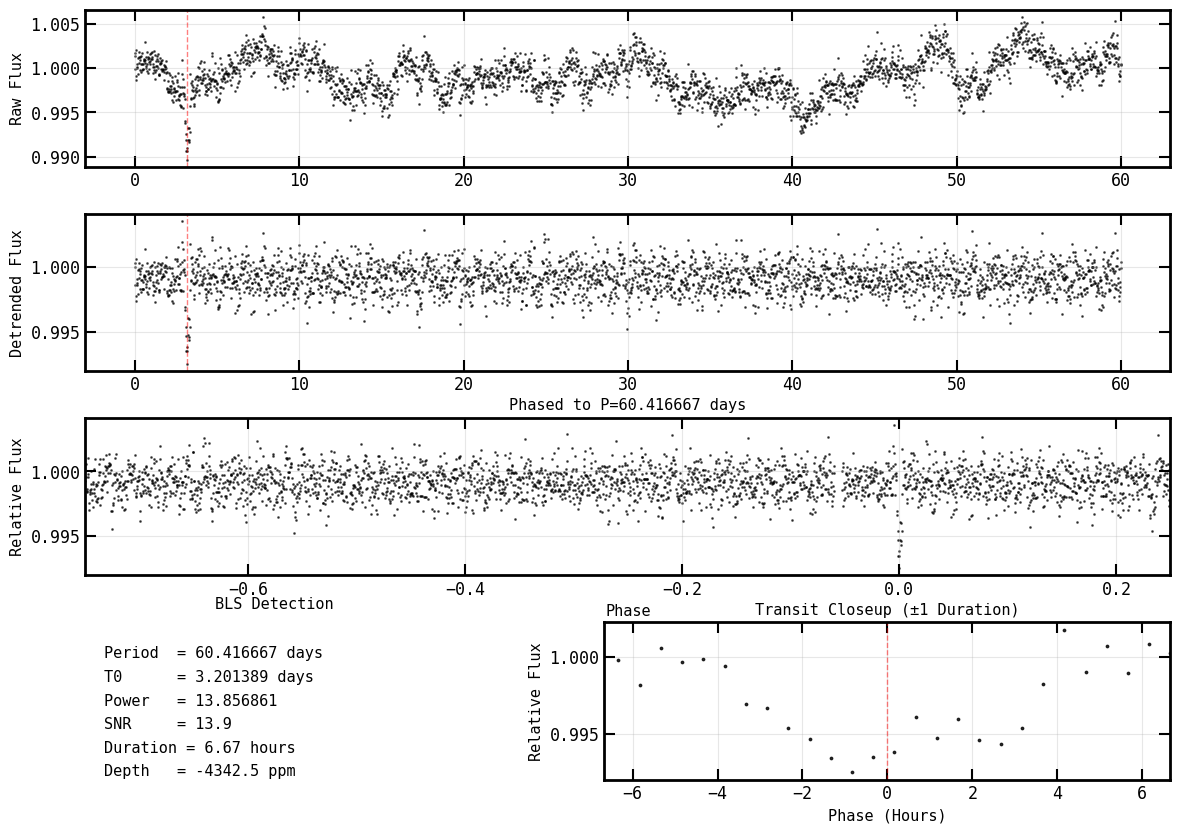

In [25]:
# Plot summary with BLS results (includes phased lightcurve and transit closeup)
fig = transitp.plot_lightcurve_summary(phot_syn, bls_ans=syn_ans, tpy5_inputs=tpy5_inputs)

## Injection/Recovery Test Suite

Comprehensive testing of BLS recovery across different period ranges and SNR levels.

We'll test:
- **Short periods**: 1-20 days
- **Medium periods**: 20-60 days  
- **Long periods**: 60-100 days
- **SNR range**: 5-30
- **Baseline**: 60 days

This will generate recovery statistics and plots showing recovery fraction vs SNR for each period regime.

In [170]:
# Import additional modules for the test suite
from pytfit5.synthetic import generate_synthetic_lightcurve, compare_bls_injection
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Configure test parameters
TIME_LENGTH = 60.0  # days - baseline length
CADENCE = 1.0/96.0  # 15-minute cadence

# Period ranges for testing
PERIOD_RANGES = {
    'short': (1, 20),      # 1-20 days
    'medium': (20, 60),    # 20-60 days  
    'long': (60, 100)      # 60-100 days
}

# SNR levels to test
SNR_LEVELS = [3, 5, 7, 10, 12, 15, 18, 20, 22, 25, 30]

# Stellar noise configurations
NOISE_CONFIGS = [
    {'type': 'none', 'amplitude': 0.0, 'label': 'White noise only'},
    {'type': 'multi', 'amplitude': 0.005, 'label': 'Multi-component (0.5%)'},
]

# Number of trials per combination
N_TRIALS = 10  # Increase for more robust statistics

print("Injection/Recovery Test Configuration:")
print(f"  Baseline length: {TIME_LENGTH} days")
print(f"  Cadence: {CADENCE*24*60:.1f} minutes")
print(f"  Period ranges: {PERIOD_RANGES}")
print(f"  SNR levels: {SNR_LEVELS}")
print(f"  Noise configurations: {len(NOISE_CONFIGS)}")
for config in NOISE_CONFIGS:
    print(f"    - {config['label']}")
print(f"  Trials per combination: {N_TRIALS}")
print(f"  Total injections: {len(PERIOD_RANGES) * len(SNR_LEVELS) * len(NOISE_CONFIGS) * N_TRIALS}")


Injection/Recovery Test Configuration:
  Baseline length: 60.0 days
  Cadence: 15.0 minutes
  Period ranges: {'short': (1, 20), 'medium': (20, 60), 'long': (60, 100)}
  SNR levels: [3, 5, 7, 10, 12, 15, 18, 20, 22, 25, 30]
  Noise configurations: 2
    - White noise only
    - Multi-component (0.5%)
  Trials per combination: 10
  Total injections: 660


In [171]:
def run_injection_recovery_test(
    period_min: float,
    period_max: float,
    snr: float,
    time_length: float = 60.0,
    cadence: float = 1.0/48.0,
    oneoverf_correction: bool = True,
    normalize: str = "iterative_baseline",
    stellar_noise_type: str = 'none',
    stellar_noise_amplitude: float = 0.0,
    seed: int = None
) -> dict:
    """
    Run a single injection/recovery test.
    
    Parameters
    ----------
    period_min, period_max : float
        Period range for random injection (days)
    snr : float
        Signal-to-noise ratio for injection
    time_length : float
        Length of lightcurve (days)
    cadence : float
        Sampling cadence (days)
    oneoverf_correction : bool
        Enable 1/f correction
    normalize : str
        Normalization method
    stellar_noise_type : str
        Type of stellar noise: 'none', 'red', 'drw', 'multi'
    stellar_noise_amplitude : float
        RMS amplitude of stellar noise
    seed : int, optional
        Random seed for reproducibility
        
    Returns
    -------
    result : dict
        Test results including injection parameters, BLS results, and recovery statistics
    """
    # Random period within range
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()
    
    period = rng.uniform(period_min, period_max)
    t0 = rng.uniform(0.5, min(period, time_length/4))  # Random phase
    depth = rng.uniform(0.003, 0.01)  # 0.3% to 1% depth
    
    # Generate synthetic lightcurve - now returns phot_class object
    phot_syn, sol_injected = generate_synthetic_lightcurve(
        t0=t0,
        per=period,
        time_length=time_length,
        depth=depth,
        snr=snr,
        cadence=cadence,
        stellar_noise_type=stellar_noise_type,
        stellar_noise_amplitude=stellar_noise_amplitude,
        seed=seed
    )
    
    # Configure BLS - using unified tpy5_inputs
    bls_inputs = tpy5.tpy5_inputs_class()
    bls_inputs.zerotime = 0.0
    bls_inputs.rstar = 1.0
    bls_inputs.mstar = 1.0
    bls_inputs.plots = 0  # No plots during batch testing
    bls_inputs.freq1 = 0.5 / time_length  # Search to 2x baseline
    bls_inputs.freq2 = 2.0  # c/d (0.5 day minimum period)
    bls_inputs.filename = "test"
    bls_inputs.oneoverf_correction = oneoverf_correction
    bls_inputs.normalize = normalize
    bls_inputs.return_spectrum = False
    
    # If we have red noise, run iterative detrending before BLS
    if stellar_noise_type != 'none' and stellar_noise_amplitude > 0:
        # Configure detrending parameters
        bls_inputs.boxbin = 2.0  # Detrending window
        bls_inputs.nfitp = 2     # Polynomial order
        bls_inputs.iter_max_iters = 5
        bls_inputs.iter_sigma_threshold = 3.0
        bls_inputs.iter_min_duration = 0.05
        
        # Run iterative detrending to protect transits
        tpy5.run_polyfilter_iterative(phot_syn, bls_inputs)
        
        # Use detrended flux for BLS
        flux_for_bls = phot_syn.flux_f
    else:
        # No red noise, use raw flux
        flux_for_bls = phot_syn.flux
    
    # Run BLS
    try:
        bls_ans = gbls.bls(bls_inputs, phot_syn.time, flux_for_bls)
        
        # Check for negative depth (invalid detection)
        if bls_ans.depth <= 0:
            result = {
                'injected_period': period,
                'injected_t0': t0,
                'injected_depth': depth,
                'injected_snr': snr,
                'stellar_noise_type': stellar_noise_type,
                'stellar_noise_amplitude': stellar_noise_amplitude,
                'bls_period': bls_ans.bper,
                'bls_snr': bls_ans.snr,
                'bls_depth': bls_ans.depth,
                'period_error': np.nan,
                'period_ratio': np.nan,
                'is_recovered': False,
                'overlap_fraction': 0.0,
                'precision': 0.0,
                'period_factor_type': 'negative_depth',
                'success': True  # BLS ran, but found invalid depth
            }
            return result
        
        # results, transit_info = pval.validate_bls_period(
        #     time=phot_syn.time,
        #     flux=phot_syn.flux_f,
        #     bls_result=syn_ans,
        #     test_factors=[0.5, 1.0, 2.0, 3.0, 4.0, 5.0],
        #     optimize_t0=True,
        #     verbose=False
        # )

        # # Handle validation results
        # if results['is_single_transit']:
        #     # Find the transit with the highest SNR
        #     max_snr_idx = np.argmax(transit_info['transit_snrs'])
        #     single_transit_time = transit_info['transit_times'][max_snr_idx]
            
        #     # Estimate period using stellar density and the highest-SNR transit
        #     P_est, P_min, is_constrained, n_transits = pval.estimate_single_transit_period(
        #         time=phot_syn.time,
        #         tdur=bls_ans.tdur,
        #         rho_star=pval.get_stellar_density(bls_inputs.mstar, bls_inputs.rstar),
        #         margin_factor=1.5
        #     )
            
        #     # Update BLS results with estimated period and highest-SNR transit time
        #     bls_ans.bper = P_est
        #     bls_ans.epo = single_transit_time
        #     bls_ans.snr = single_transit_snr   # Update with single transit SNR
        
        # Create BLS solution object for comparison
        sol_bls = transitm.transit_model_class()
        sol_bls.npl = 1
        sol_bls.t0 = [bls_ans.epo]
        sol_bls.per = [bls_ans.bper]
        sol_bls.bb = [0.5]
        sol_bls.rdr = [np.sqrt(bls_ans.depth)]
        sol_bls.rho = sol_injected.rho
        
        # Calculate recovery statistics - now passing phot_syn object
        recovery = compare_bls_injection(
            phot=phot_syn,  # Pass phot_class object
            sol_injected=sol_injected,
            sol_bls=sol_bls,
            verbose=False
        )
        
        # Compile results
        result = {
            'injected_period': period,
            'injected_t0': t0,
            'injected_depth': depth,
            'injected_snr': snr,
            'stellar_noise_type': stellar_noise_type,
            'stellar_noise_amplitude': stellar_noise_amplitude,
            'bls_period': bls_ans.bper,
            'bls_snr': bls_ans.snr,
            'bls_depth': bls_ans.depth,
            'period_error': abs(bls_ans.bper - period),
            'period_ratio': bls_ans.bper / period,
            'is_recovered': recovery['is_recovered'],
            'overlap_fraction': recovery['overlap_fraction'],
            'precision': recovery['precision'],
            'period_factor_type': recovery['period_factor_type'],
            'success': True
        }
        
    except Exception as e:
        # Handle BLS failures
        result = {
            'injected_period': period,
            'injected_t0': t0,
            'injected_depth': depth,
            'injected_snr': snr,
            'stellar_noise_type': stellar_noise_type,
            'stellar_noise_amplitude': stellar_noise_amplitude,
            'bls_period': np.nan,
            'bls_snr': np.nan,
            'bls_depth': np.nan,
            'period_error': np.nan,
            'period_ratio': np.nan,
            'is_recovered': False,
            'overlap_fraction': 0.0,
            'precision': 0.0,
            'period_factor_type': 'error',
            'success': False,
            'error': str(e)
        }
    
    return result


In [172]:
# Run the full test suite
results = []

# Total number of tests
total_tests = len(PERIOD_RANGES) * len(SNR_LEVELS) * len(NOISE_CONFIGS) * N_TRIALS

print(f"\nRunning {total_tests} injection/recovery tests...")
print("=" * 70)

# Use tqdm for progress tracking
with tqdm(total=total_tests, desc="Testing", unit="test") as pbar:
    for noise_config in NOISE_CONFIGS:
        for period_range_name, (period_min, period_max) in PERIOD_RANGES.items():
            for snr in SNR_LEVELS:
                for trial in range(N_TRIALS):
                    # Use different seed for each trial
                    seed = hash((noise_config['type'], noise_config['amplitude'], period_range_name, snr, trial)) % (2**31)
                    
                    result = run_injection_recovery_test(
                        period_min=period_min,
                        period_max=period_max,
                        snr=snr,
                        time_length=TIME_LENGTH,
                        cadence=CADENCE,
                        oneoverf_correction=True,  # Test with correction enabled
                        normalize="iterative_baseline",
                        stellar_noise_type=noise_config['type'],
                        stellar_noise_amplitude=noise_config['amplitude'],
                        seed=seed
                    )
                    
                    # Add metadata
                    result['period_range'] = period_range_name
                    result['noise_config'] = noise_config['label']
                    result['trial'] = trial
                    
                    results.append(result)
                    pbar.update(1)

# Convert to DataFrame for easy analysis
df_results = pd.DataFrame(results)

print("\n" + "=" * 70)
print("Test suite completed!")
print(f"Total tests: {len(df_results)}")
print(f"Successful BLS runs: {df_results['success'].sum()}")
print(f"Recovered transits: {df_results['is_recovered'].sum()}")
print(f"Overall recovery rate: {df_results['is_recovered'].sum() / len(df_results) * 100:.1f}%")

# Show recovery by noise configuration
print(f"\nRecovery by Noise Configuration:")
for noise_label in df_results['noise_config'].unique():
    data = df_results[df_results['noise_config'] == noise_label]
    n_recovered = data['is_recovered'].sum()
    n_total = len(data)
    rate = n_recovered / n_total * 100 if n_total > 0 else 0
    print(f"  {noise_label:30s}: {n_recovered:3d}/{n_total:3d} ({rate:5.1f}%)")



Running 660 injection/recovery tests...


Testing: 100%|██████████| 660/660 [58:05<00:00,  5.28s/test]


Test suite completed!
Total tests: 660
Successful BLS runs: 660
Recovered transits: 390
Overall recovery rate: 59.1%

Recovery by Noise Configuration:
  White noise only              : 228/330 ( 69.1%)
  Multi-component (0.5%)        : 162/330 ( 49.1%)


In [173]:
# Calculate recovery statistics by period range, SNR, and noise configuration
recovery_stats = df_results.groupby(['noise_config', 'period_range', 'injected_snr']).agg({
    'is_recovered': ['sum', 'count', 'mean'],
    'overlap_fraction': 'mean',
    'period_ratio': 'mean',
    'bls_snr': 'mean'
}).reset_index()

# Flatten column names
recovery_stats.columns = ['noise_config', 'period_range', 'snr', 'n_recovered', 'n_total', 'recovery_fraction', 
                          'mean_overlap', 'mean_period_ratio', 'mean_bls_snr']

print("\nRecovery Statistics by Noise Config, Period Range and SNR:")
print("=" * 120)
print(recovery_stats.to_string(index=False))
print("=" * 120)



Recovery Statistics by Noise Config, Period Range and SNR:
          noise_config period_range  snr  n_recovered  n_total  recovery_fraction  mean_overlap  mean_period_ratio  mean_bls_snr
Multi-component (0.5%)         long    3            0       10                0.0      0.026667           0.035313     -2.071977
Multi-component (0.5%)         long    5            0       10                0.0      0.127179           0.028291      3.615989
Multi-component (0.5%)         long    7            0       10                0.0      0.127875           0.115346     -1.242450
Multi-component (0.5%)         long   10            0       10                0.0      0.334669           0.246931      1.853749
Multi-component (0.5%)         long   12            0       10                0.0      0.338960           0.207361      2.780942
Multi-component (0.5%)         long   15            0       10                0.0      0.511205           0.188988      7.613317
Multi-component (0.5%)         long  

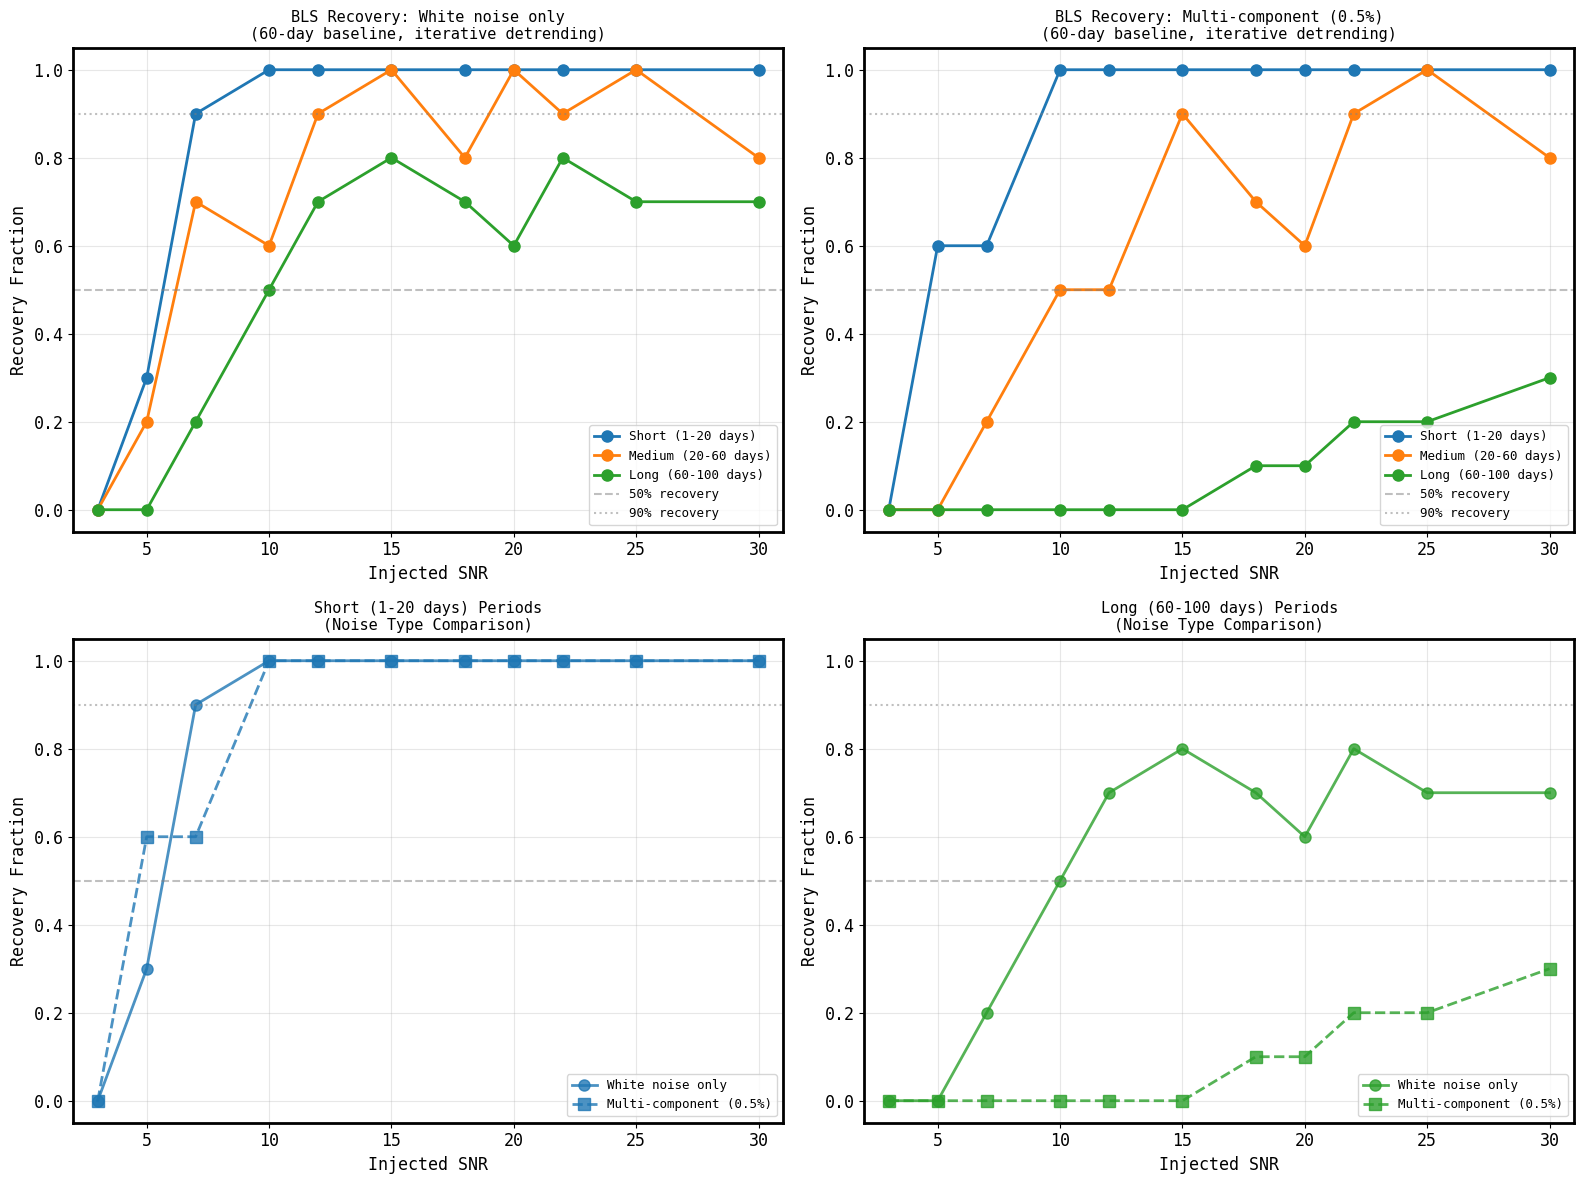


Plot generated: Recovery fraction vs SNR comparing white noise and red noise


In [174]:
# Plot recovery fraction vs SNR for each period range, comparing noise types
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define colors for each period range
colors = {
    'short': '#1f77b4',   # blue
    'medium': '#ff7f0e',  # orange
    'long': '#2ca02c'     # green
}

labels = {
    'short': 'Short (1-20 days)',
    'medium': 'Medium (20-60 days)',
    'long': 'Long (60-100 days)'
}

# Get unique noise configurations
noise_configs = df_results['noise_config'].unique()

# Top row: Recovery fraction vs SNR for each noise configuration
for idx, noise_config in enumerate(noise_configs):
    ax = axes[0, idx]
    data_noise = recovery_stats[recovery_stats['noise_config'] == noise_config]
    
    for period_range in ['short', 'medium', 'long']:
        data = data_noise[data_noise['period_range'] == period_range]
        ax.plot(data['snr'], data['recovery_fraction'], 
                 marker='o', linewidth=2, markersize=8,
                 color=colors[period_range], label=labels[period_range])
    
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% recovery')
    ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5, label='90% recovery')
    ax.set_xlabel('Injected SNR', fontsize=12)
    ax.set_ylabel('Recovery Fraction', fontsize=12)
    ax.set_title(f'BLS Recovery: {noise_config}\n(60-day baseline, iterative detrending)', fontsize=11)
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(min(SNR_LEVELS)-1, max(SNR_LEVELS)+1)
    ax.set_ylim(-0.05, 1.05)

# Bottom row: Direct comparison for each period range
for idx, period_range in enumerate(['short', 'long']):
    ax = axes[1, idx]
    
    for noise_config in noise_configs:
        data = recovery_stats[(recovery_stats['noise_config'] == noise_config) & 
                              (recovery_stats['period_range'] == period_range)]
        marker = 'o' if 'White' in noise_config else 's'
        linestyle = '-' if 'White' in noise_config else '--'
        ax.plot(data['snr'], data['recovery_fraction'], 
                marker=marker, linewidth=2, markersize=8,
                color=colors[period_range], label=noise_config,
                linestyle=linestyle, alpha=0.8)
    
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Injected SNR', fontsize=12)
    ax.set_ylabel('Recovery Fraction', fontsize=12)
    ax.set_title(f'{labels[period_range]} Periods\n(Noise Type Comparison)', fontsize=11)
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(min(SNR_LEVELS)-1, max(SNR_LEVELS)+1)
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\nPlot generated: Recovery fraction vs SNR comparing white noise and red noise")


/tmp/ipykernel_2067218/3656815942.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_snr['period_bin'] = pd.cut(data_snr['injected_period'], bins=period_bins)
/tmp/ipykernel_2067218/3656815942.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recovery_by_period_snr = data_snr.groupby('period_bin')['is_recovered'].mean()
/tmp/ipykernel_2067218/3656815942.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt 

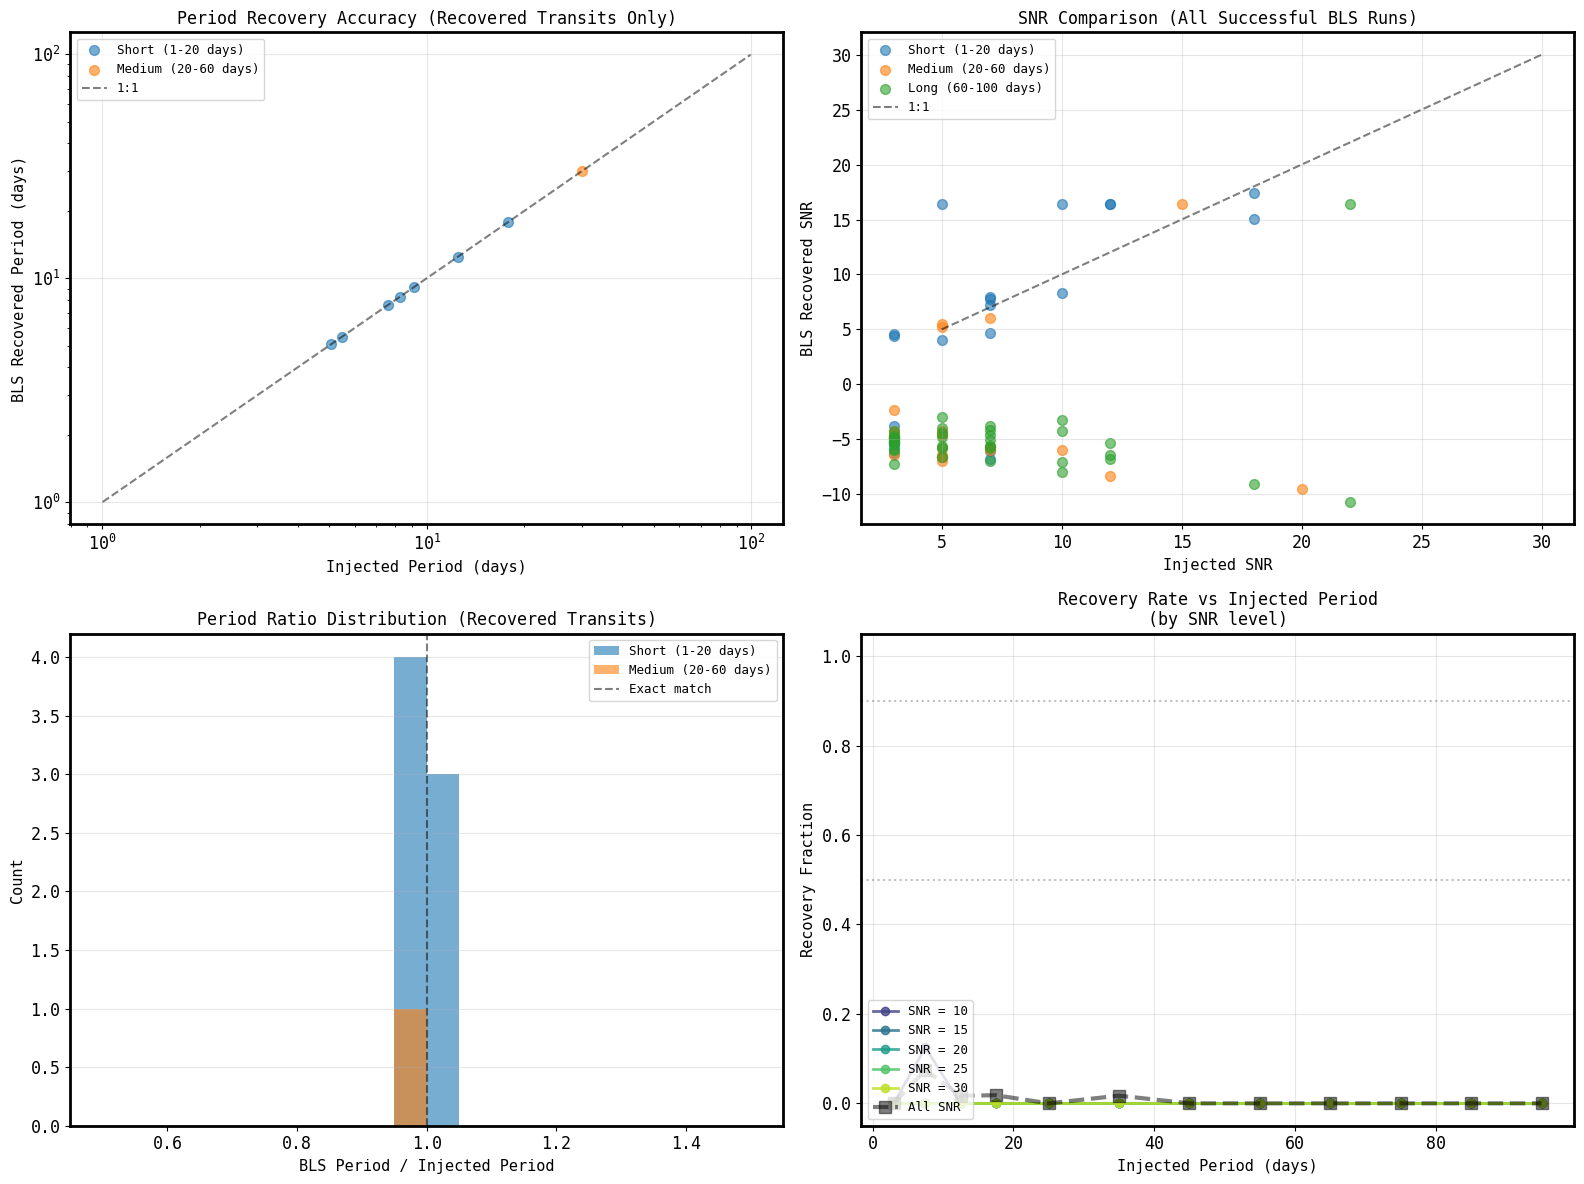


Diagnostic plots generated:


In [164]:
# Additional diagnostic plots

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Period recovery accuracy (for recovered transits)
ax = axes[0, 0]
for period_range in ['short', 'medium', 'long']:
    data = df_results[(df_results['period_range'] == period_range) & (df_results['is_recovered'] == True)]
    if len(data) > 0:
        ax.scatter(data['injected_period'], data['bls_period'], 
                  alpha=0.6, s=50, color=colors[period_range], label=labels[period_range])

# Add 1:1 line
min_per, max_per = df_results['injected_period'].min(), df_results['injected_period'].max()
ax.plot([min_per, max_per], [min_per, max_per], 'k--', alpha=0.5, label='1:1')
ax.set_xlabel('Injected Period (days)', fontsize=11)
ax.set_ylabel('BLS Recovered Period (days)', fontsize=11)
ax.set_title('Period Recovery Accuracy (Recovered Transits Only)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

# 2. SNR comparison
ax = axes[0, 1]
for period_range in ['short', 'medium', 'long']:
    data = df_results[(df_results['period_range'] == period_range) & (df_results['success'] == True)]
    if len(data) > 0:
        ax.scatter(data['injected_snr'], data['bls_snr'], 
                  alpha=0.6, s=50, color=colors[period_range], label=labels[period_range])

# Add 1:1 line
ax.plot([5, 30], [5, 30], 'k--', alpha=0.5, label='1:1')
ax.set_xlabel('Injected SNR', fontsize=11)
ax.set_ylabel('BLS Recovered SNR', fontsize=11)
ax.set_title('SNR Comparison (All Successful BLS Runs)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 3. Period ratio distribution
ax = axes[1, 0]
for period_range in ['short', 'medium', 'long']:
    data = df_results[(df_results['period_range'] == period_range) & (df_results['is_recovered'] == True)]
    if len(data) > 0:
        ax.hist(data['period_ratio'], bins=20, alpha=0.6, 
               color=colors[period_range], label=labels[period_range], range=(0.5, 1.5))

ax.axvline(x=1.0, color='k', linestyle='--', alpha=0.5, label='Exact match')
ax.set_xlabel('BLS Period / Injected Period', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Period Ratio Distribution (Recovered Transits)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

# 4. Recovery rate by injected period (by SNR level)
ax = axes[1, 1]
# Bin periods and calculate recovery rate
period_bins = [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df_results['period_bin'] = pd.cut(df_results['injected_period'], bins=period_bins)
bin_centers = [(period_bins[i] + period_bins[i+1])/2 for i in range(len(period_bins)-1)]

# Plot recovery rate for selected SNR levels
snr_to_plot = [10, 15, 20, 25, 30]  # Select representative SNR levels
snr_colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(snr_to_plot)))

for snr, color in zip(snr_to_plot, snr_colors):
    data_snr = df_results[df_results['injected_snr'] == snr]
    if len(data_snr) > 0:
        data_snr['period_bin'] = pd.cut(data_snr['injected_period'], bins=period_bins)
        recovery_by_period_snr = data_snr.groupby('period_bin')['is_recovered'].mean()
        ax.plot(bin_centers, recovery_by_period_snr.values, marker='o', linewidth=2, 
                markersize=6, color=color, label=f'SNR = {snr:.0f}', alpha=0.8)

# Add overall recovery line (all SNR combined)
recovery_by_period_all = df_results.groupby('period_bin')['is_recovered'].mean()
ax.plot(bin_centers, recovery_by_period_all.values, marker='s', linewidth=3, 
        markersize=8, color='black', label='All SNR', alpha=0.5, linestyle='--')

ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Injected Period (days)', fontsize=11)
ax.set_ylabel('Recovery Fraction', fontsize=11)
ax.set_title('Recovery Rate vs Injected Period\n(by SNR level)', fontsize=12)
ax.legend(fontsize=9, loc='lower left')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\nDiagnostic plots generated:")

In [ ]:
# Summary statistics
print("\n" + "="*80)
print("INJECTION/RECOVERY TEST SUMMARY")
print("="*80)

print(f"\nTest Configuration:")
print(f"  Baseline: {TIME_LENGTH} days")
print(f"  Cadence: {CADENCE*24*60:.1f} minutes")
print(f"  Normalization: iterative_baseline")
print(f"  1/f Correction: Enabled")
print(f"  Detrending: Iterative (for red noise cases)")
print(f"  Trials per combination: {N_TRIALS}")

print(f"\nOverall Results:")
print(f"  Total tests: {len(df_results)}")
print(f"  Successful BLS runs: {df_results['success'].sum()} ({df_results['success'].mean()*100:.1f}%)")
print(f"  Recovered transits: {df_results['is_recovered'].sum()} ({df_results['is_recovered'].mean()*100:.1f}%)")

print(f"\nRecovery by Noise Configuration:")
for noise_config in df_results['noise_config'].unique():
    data = df_results[df_results['noise_config'] == noise_config]
    n_recovered = data['is_recovered'].sum()
    n_total = len(data)
    rate = n_recovered / n_total * 100 if n_total > 0 else 0
    print(f"  {noise_config:30s}: {n_recovered:3d}/{n_total:3d} ({rate:5.1f}%)")

print(f"\nRecovery by Period Range and Noise:")
for noise_config in df_results['noise_config'].unique():
    print(f"\n  {noise_config}:")
    for period_range in ['short', 'medium', 'long']:
        data = df_results[(df_results['noise_config'] == noise_config) & 
                          (df_results['period_range'] == period_range)]
        n_recovered = data['is_recovered'].sum()
        n_total = len(data)
        rate = n_recovered / n_total * 100 if n_total > 0 else 0
        print(f"    {labels[period_range]:25s}: {n_recovered:3d}/{n_total:3d} ({rate:5.1f}%)")

print(f"\nRecovery by SNR Level (All Noise Types):")
for snr in sorted(df_results['injected_snr'].unique()):
    data = df_results[df_results['injected_snr'] == snr]
    n_recovered = data['is_recovered'].sum()
    n_total = len(data)
    rate = n_recovered / n_total * 100 if n_total > 0 else 0
    print(f"  SNR = {snr:4.0f}: {n_recovered:3d}/{n_total:3d} ({rate:5.1f}%)")

print(f"\nCritical SNR for 90% Recovery:")
for noise_config in df_results['noise_config'].unique():
    print(f"\n  {noise_config}:")
    for period_range in ['short', 'medium', 'long']:
        stats = recovery_stats[(recovery_stats['noise_config'] == noise_config) & 
                               (recovery_stats['period_range'] == period_range)]
        above_90 = stats[stats['recovery_fraction'] >= 0.9]
        if len(above_90) > 0:
            min_snr = above_90['snr'].min()
            print(f"    {labels[period_range]:25s}: SNR ≥ {min_snr:.0f}")
        else:
            print(f"    {labels[period_range]:25s}: >30 (not reached)")

print(f"\nPeriod Aliasing Analysis (Recovered Transits):")
recovered = df_results[df_results['is_recovered'] == True]
if len(recovered) > 0:
    alias_counts = recovered['period_factor_type'].value_counts()
    print(f"  Exact matches: {alias_counts.get('exact', 0)} ({alias_counts.get('exact', 0)/len(recovered)*100:.1f}%)")
    print(f"  Multiples:     {alias_counts.get('multiple', 0)} ({alias_counts.get('multiple', 0)/len(recovered)*100:.1f}%)")
    print(f"  Fractions:     {alias_counts.get('fraction', 0)} ({alias_counts.get('fraction', 0)/len(recovered)*100:.1f}%)")
    print(f"  Close matches: {alias_counts.get('close', 0)} ({alias_counts.get('close', 0)/len(recovered)*100:.1f}%)")

print("\n" + "="*80)



INJECTION/RECOVERY TEST SUMMARY

Test Configuration:
  Baseline: 60.0 days
  Cadence: 30.0 minutes
  Normalization: iterative_baseline
  1/f Correction: Enabled
  Trials per combination: 100

Overall Results:
  Total tests: 3000
  Successful BLS runs: 3000 (100.0%)
  Recovered transits: 2258 (75.3%)

Recovery by Period Range:
  Short (1-20 days)        : 940/1000 ( 94.0%)
  Medium (20-60 days)      : 795/1000 ( 79.5%)
  Long (60-100 days)       : 523/1000 ( 52.3%)

Recovery by SNR Level:
  SNR =    5:  66/300 ( 22.0%)
  SNR =    7: 165/300 ( 55.0%)
  SNR =   10: 211/300 ( 70.3%)
  SNR =   12: 243/300 ( 81.0%)
  SNR =   15: 266/300 ( 88.7%)
  SNR =   18: 253/300 ( 84.3%)
  SNR =   20: 270/300 ( 90.0%)
  SNR =   22: 257/300 ( 85.7%)
  SNR =   25: 256/300 ( 85.3%)
  SNR =   30: 271/300 ( 90.3%)

Critical SNR for 90% Recovery:
  Short (1-20 days)        : SNR ≥ 7
  Medium (20-60 days)      : SNR ≥ 15
  Long (60-100 days)       : >30 (not reached)

Period Aliasing Analysis (Recovered Trans

In [119]:
# Optional: Save results to CSV for further analysis
csv_filename = "injection_recovery_results.csv"
df_results.to_csv(csv_filename, index=False)
print(f"\nResults saved to: {csv_filename}")

# Optional: Save summary statistics
summary_filename = "injection_recovery_summary.csv"
recovery_stats.to_csv(summary_filename, index=False)
print(f"Summary statistics saved to: {summary_filename}")


Results saved to: injection_recovery_results.csv
Summary statistics saved to: injection_recovery_summary.csv
